# Programming Exercise 2
**Christian Steinmetz**

Due on November 27th

Pick a binary classification dataset from the LIBSVM repository:
http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/


In [8]:
import sys
import time
import graphviz 
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import IFrame
import matplotlib as mpl

from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm
from sklearn import model_selection
from sklearn import neural_network

from matplotlib.colors import Normalize

mpl.rcParams['figure.dpi'] = 100
%config InlineBackend.figure_format = 'retina'

## Dataset
For this exercise we the [Mushrooms dataset](https://www.kaggle.com/uciml/mushroom-classification/data), which includes features from different mushroom species and a label of whether or not the mushroom is safe to eat or poisonous. For this task, given a set of mushroom features, we want to predict whether or not it is safe to eat the mushroom. 

<img src='https://images.unsplash.com/photo-1512595765784-5ebad80772a3?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=800&q=60)' width=400>


## Loading and pre-processing
First we will load the data from the .csv file using pandas and then process it so that all of the features are encoded as numbers, since they are encoded as strings in the original dataset. We will then also split the data into instance features, $X$ and labels, $Y$.

In [199]:
df = pd.read_csv("./data/mushrooms.csv", dtype='category')
df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


**Note:** This may not be the best pre-processing to apply to this categorical data. It may instead be better to use one-hot-encoding since integer values of 1, 2, 3, etc. imply there is more 'distance' between category 1 and 3 than category 1 and 2, but this is not the case, since our categories do not have a notion of 'distance'. Using this kind of encoding comes at the cost of increasing the number of input features though, so for simplicity we use simple integer encoding and observe how the models can perfom (still quite good as we will see).

In [227]:
# this function lets us specifty a train/test split
# and then randomly sample datapoints for each set
def get_data(df, train_split, one_hot_encode=False):
    
    cat_columns = df.columns[df.columns != 'class']

    if one_hot_encode:
        # use pandas dummies to one hot encode all categorical features
        df = pd.get_dummies(df, prefix_sep="_", columns=cat_columns)
        df['class'] = preprocessing.LabelEncoder().fit_transform(df['class'])
    else:
        # use the label encoder to convert the string labels to integers
        df = df.apply(preprocessing.LabelEncoder().fit_transform)
      
    train_idx = np.random.choice(np.arange(len(df)), size=(int(len(df)*train_split)), replace=False)
    test_idx  = [idx for idx in np.arange(len(df)) if idx not in train_idx]

    y_train = df.loc[train_idx, 'class']
    x_train = df.loc[train_idx, df.columns != 'class']

    y_test = df.loc[test_idx, 'class']
    x_test = df.loc[test_idx, df.columns != 'class']
    
    return x_train, y_train, x_test, y_test


## 1. Decision Trees
Partition the dataset into a training and a testing set.
Run a decision tree learning algorithm usign the training set. Test the
decision tree on the testing dataset and report the total classification error
(i.e. 0/1 error). Repeat the experiment with a different partition. Plot
the resulting trees. Are they very similar, or very different? Explain why.

Advice: it can be convenient to set a maximum depth for the tree.

In [6]:
def graph_tree(trained_tree, name="tree"):
    dot_data = tree.export_graphviz(trained_tree,  
                    out_file=None, feature_names=df.columns[1:23],
                    class_names=["p", "e"], rounded=True, proportion=False, 
                    precision=2, filled = True)
    graph = graphviz.Source(dot_data) 
    graph.format = 'svg'
    graph.render(f"./plots/{name}") 
    return IFrame(f"./plots/{name}.svg", width='100%', height=800)

In [7]:
x_train, y_train, x_test, y_test = get_data(0.8)
clfA = tree.DecisionTreeClassifier(random_state=0, max_depth=4)
clfA = clfA.fit(x_train, y_train)
y_hat = clfA.predict(x_test)
acc = metrics.accuracy_score(y_test, y_hat)
print(acc)

0.9753846153846154


In [8]:
x_train, y_train, x_test, y_test = get_data(int(len(df)*0.8))
clfB = tree.DecisionTreeClassifier(random_state=42, max_depth=4)
clfB = clfB.fit(x_train, y_train)
y_hat = clfB.predict(x_test)
acc = metrics.accuracy_score(y_test, y_hat)
print(acc)

0.9778461538461538


Let's observe the two different trees that were trained on different data

In [9]:
graph_tree(clfA, name="treeA")

In [10]:
graph_tree(clfB, name="treeB")

We notice that the two trees learn different things, but they do share some similiar qualities. This deviation between trees increases as the depth of the trees increase, since their are more degress of freedom. We actually found that when the depth was less than 3, with out dataset, both trees learned the same leaves, even with many different random samples of the data. 

In [89]:
x_train, y_train, x_test, y_test = get_data(int(len(df)*0.8))
clf = tree.DecisionTreeClassifier(random_state=0, max_depth=7)
clf = clf.fit(x_train, y_train)
y_hat = clf.predict(x_test)
acc = metrics.accuracy_score(y_test, y_hat)
print(acc*100, "%")

100.0 %


With a depth of 7 we are able to get 100% accuracy on the test set.

## 2. Support Vector Machines
Run SVM to train a classifier, using radial basis as kernel function. Apply cross-validation to evaluate different
combinations of values of the model hyper-parameters (box constraint $C$
and kernel parameter $\gamma$). How sensitive is the cross-validation error to
changes in $C$ and $\gamma$? Choose the combination of $C$ and $\gamma$ that minimizes
the cross-validation error, train the SVM on the entire dataset and report
the total classification error.

Advice: use a logaritmic range for $\gamma$.

In [40]:
def train_svm(x_train, y_train, gamma, C):
    clf = svm.SVC(gamma=gamma, C=C, kernel="rbf")
    clf.fit(x_train, y_train)
    return clf

We will take 80% of the data and perform cross-validation on 5 folds of this data to exammine the performance of each SVM classifier as the values of $\gamma$ and $C$ are varied. Afterwards, we retrain the classifier that showed the lowest cross-validation error with the complete test set (80% of complete dataset) and then evaluate the final model on the remaining test set. 

In [66]:
x_train, y_train, x_test, y_test = get_data(int(len(df)*0.8))

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
scores = np.empty(shape=(len(C_range),len(gamma_range)))

for gamma_idx, gamma in enumerate(gamma_range):
    for C_idx, C in enumerate(C_range):
        clf = svm.SVC(gamma=gamma, C=C, kernel="rbf")
        scores[C_idx, gamma_idx] = model_selection.cross_val_score(clf, x_train, y_train, cv=5).mean()
        n_clf = gamma_idx*len(C_range) + C_idx
        total_clf = len(gamma_range)*len(C_range)
        sys.stdout.write(f"* Fit {n_clf+1:3d}/{total_clf:3d} SVM classifiers...\r")
        sys.stdout.flush()
print("Done.")

Done. 169/169 SVM classifiers...


After we have computed all the cross-validation scores across different values of $C$ and $\gamma$, we will make a plot to visualize the effect of these hyperparameters on the accuracy of the classifier. We modify [code](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html) based on the documentation for sklearn to do this, where we make a heatmap showing the accuracy.  

In [67]:
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

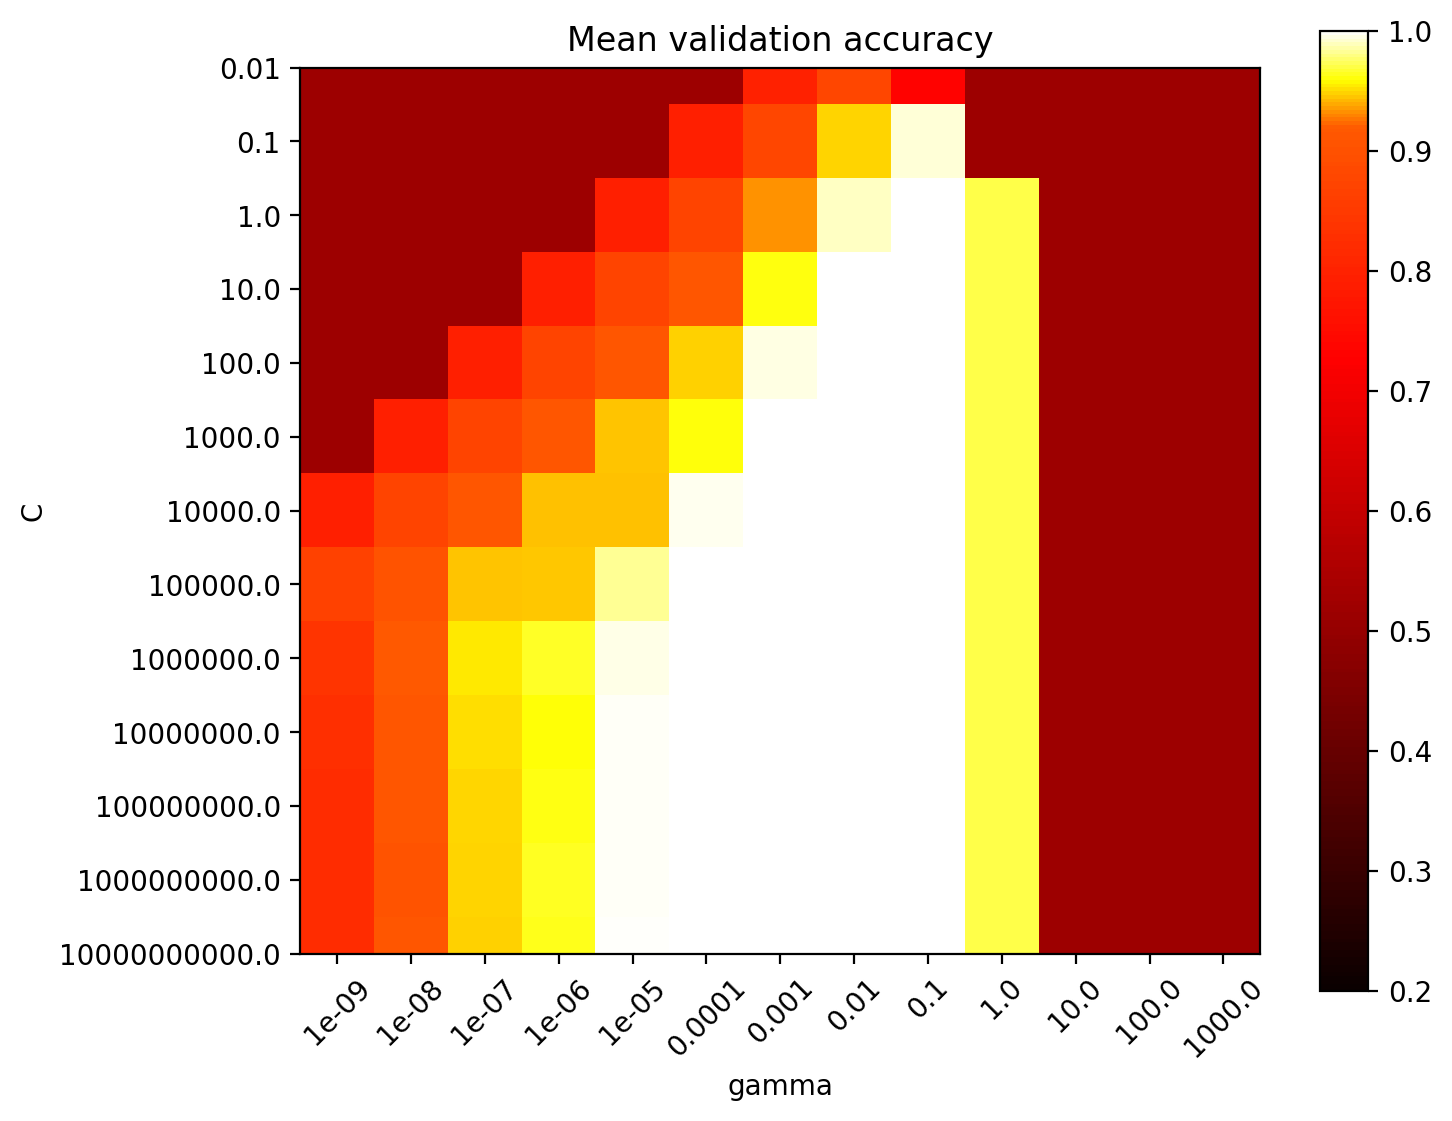

In [68]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Mean validation accuracy')
plt.show()

In [85]:
C_best_idx, gamma_best_idx = np.where(scores == np.amax(scores))
gamma_val_best = gamma_range[gamma_best_idx[0]]
C_val_best = C_range[C_best_idx[0]]
best_score = scores[C_best_idx[0], gamma_best_idx[0]]

print(f"Best results are given for gamma={gamma_val_best}a nd C={C_val_best} with acc={best_score*100}%")

Best results are given for gamma=0.1a nd C=1.0 with acc=100.0%


Our results above that there is a range of hyperparmaters over which our classifier is achieving 100% accuracy. We will retrain the SVM with these values and then evaluate on the test set, which has not been used at all during this process so far.

While it may be somewhat concerning that we achieve 100% accuracy on this dataset, it should be noted that these results have been achieved [elsewhere](https://towardsdatascience.com/building-a-perfect-mushroom-classifier-ceb9d99ae87e) as well. Furthermore, we hypothesize this is due to the fact that this dataset was crafted for mostly education purposes, and therefore may contain less noise than other real-world datasets.

In [88]:
clf = svm.SVC(gamma=gamma_val_best, C=C_val_best, kernel="rbf")
clf.fit(x_train, y_train)
y_hat = clf.predict(x_test)
acc = metrics.accuracy_score(y_test, y_hat)
print(f"{acc*100}%")

100.0%


## Neural Networks
Train a Multi-Layer perceptron using the crossentropy loss with $-2$ regularization (weight decay penalty). In other
words, the activation function equals the logistic function. Plot curves
of the training and validation error as a function of the penalty strength
$\alpha$. How do the curves behave? Explain why.

Advice: use a logaritmic range for hyper-parameter $\alpha$.. Experiment with
different sizes of the training/validation sets and different model parameters (network layers).

### Titanic dataset
I was having a good deal of trouble getting the desired trends for the plot of training and validation loss over different values of alpha due to the simplicity of the mushroom dataset. Therefore, here we will anaylize the famous Titantic dataset, where we use features from the different passengers to attempt to predict whether or not they survied.

In [2]:
df = pd.read_csv("./data/titanic/train.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


To make things simpler we will throw away some features (name, ticket, and cabin) since these are a bit trickier to work with. Then we will one-hot-encode the categorical values like sex and embarked. 

In [19]:
df_processed = df.drop(['Name', 'Ticket', 'Cabin'], axis=1)

In [20]:
def encode_dataframe(df, split):
    
    N = len(df)
    s = int(split*N)
    
    cat_columns = ['Sex', 'Embarked']
    
    # normalize numerical features
    df['Pclass'] = df['Pclass'] / np.max(df['Pclass'])
    df['SibSp'] = df['SibSp'] / np.max(df['SibSp'])
    df['Parch'] = df['Parch'] / np.max(df['Parch'])
    df['Age'] = df['Age'] / np.max(df['Age'])
    df['Fare'] = df['Fare'] / np.max(df['Fare'])
    
    # remove any rows with NaNs
    df = df.dropna()
    
    # use pandas dummies to one hot encode all categorical features
    df_processed = pd.get_dummies(df, prefix_sep="_", columns=cat_columns)    

    y_train = df_processed.loc[:s,'Survived']
    x_train = df_processed.loc[:s, df_processed.columns != 'Survived']
    
    y_test = df_processed.loc[s:,'Survived']
    x_test = df_processed.loc[s:, df_processed.columns != 'Survived']
    
    
    return x_train, y_train, x_test, y_test

In [69]:
x_train, y_train, x_test, y_test = encode_dataframe(df_processed, 0.60)
print("Training: ", x_train.shape, y_train.shape)
print("Testing: ", x_test.shape, y_test.shape)

Training:  (423, 11) (423,)
Testing:  (290, 11) (290,)


In [105]:
alpha = np.logspace(-4, 0, num=100, base=10)
alpha = np.concatenate((np.array([0.0]), alpha))
n_trials = 10
n_clf = 0

# logging
train_acc = []
val_acc = []

for a in alpha:
    for trial in np.arange(n_trials):

        # arrays to hold trial acc
        t_acc = []
        v_acc = []
    
        clf = neural_network.MLPClassifier(solver='adam', activation='logistic', max_iter=1000, 
                                           n_iter_no_change=10, random_state=trial,
                                           alpha=a, hidden_layer_sizes=(50,25))
        clf.fit(x_train, y_train)

        n_clf += 1
        sys.stdout.write(f"* Fit {n_clf:3d}/{len(alpha)*n_trials:3d} MLP classifiers...\r")
        sys.stdout.flush()
    
        # calculate losses        
        t_acc.append(clf.score(x_train, y_train))
        v_acc.append(clf.score(x_test, y_test))
    
    train_acc.append(np.array(t_acc).mean())
    val_acc.append(np.array(v_acc).mean())
    

Text(0.5, 1.0, 'Effect of alpha hyperparameter on overfitting of MLP')

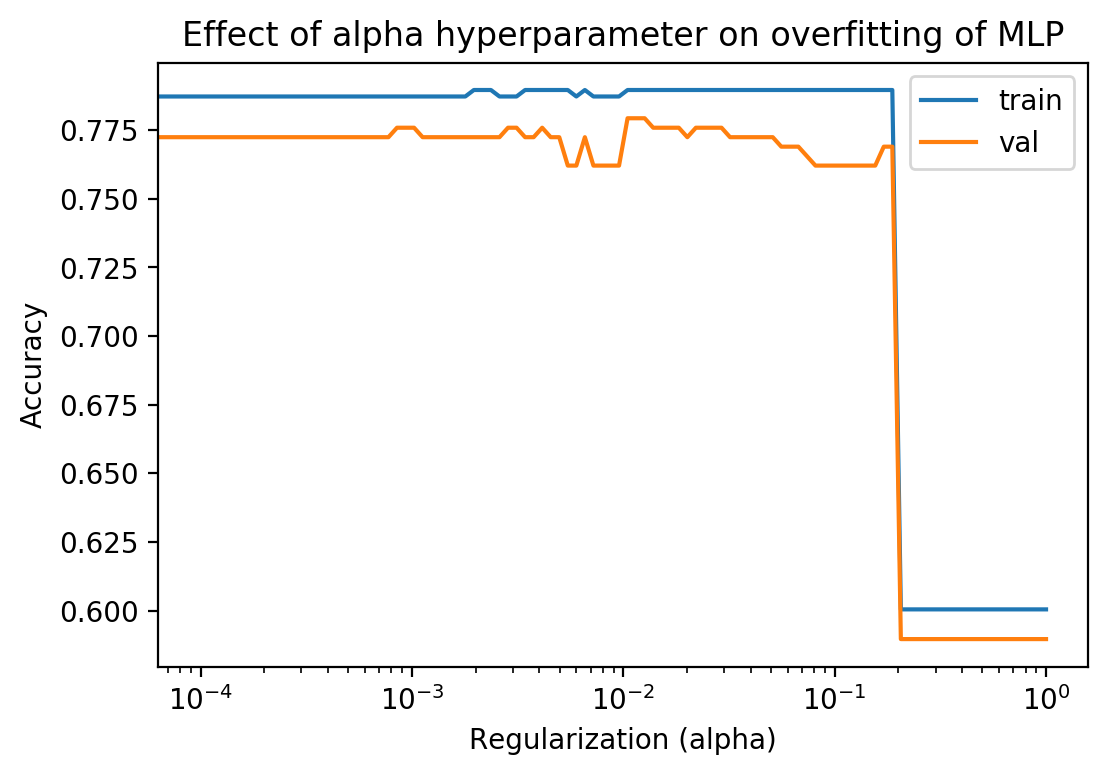

In [106]:
plt.semilogx(alpha, train_acc)
plt.semilogx(alpha, val_acc)
plt.legend(['train', 'val'])
plt.ylabel("Accuracy")
plt.xlabel("Regularization (alpha)")
plt.title("Effect of alpha hyperparameter on overfitting of MLP")

### Summay
I spent a bit of time trying to tweak the model parameters and the data split in order to get the results I was hoping to display, but I still had a challenge in showing that perfectly. Essentially, we hope to show that by increasing the L2 regualarization parameter $\alpha$, we can help reduce overfitting present in the model. We also only give the model 60% of the data and increase the size of the hidden layers, in hopes that this will cause overfitting on the training data. Therefore, we when increase $\alpha$ we expect to see this overfitting decrease. 

It is clear to see that when the parameter becomes very large (over $\alpha=0.5$) the accuracy of the model on both the training set and the test set decreases drastically. There is a point right around $\alpha=0.2$ where the training loss and validation loss are equal indicating that we have balanced overfitting in some way, but this case may not be ideal, because even though we have overfitting with lower values, in some cases we actually have a greater validation accuracy than at this point. 

In this case, we fit 10 models for every value of $\alpha$ and then average the accuracy, so the hope was to try to achieve a smoother curve this way. Ideally, as we increase $\alpha$ we would hope to see the validation accuracy increase and the training accuracy decrease somewhat until there is a point where they meet, hence reducing any overfitting.